In this file, I do the simulation of SGM (Mar 27, 2023)

1. I generate SGM parameters from ARMA model 

2. With them, I generate the corresponding PSD. 

3. I train RNN and CNN to see whether we can recover the SGM parmaters or not

## Import pkg

In [2]:
import sys
sys.path.append("../../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [4]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm_fixed import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time

In [5]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)


## Data, fn and parameters

In [6]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()


In [7]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = np.linspace(2, 45, 40)


In [8]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
paras_run.k = 1 # the parameter for reparameterization in logistic

In [9]:
# to generate ARMA TS
from statsmodels.tsa.arima_process import arma_generate_sample

def gen_arma_ts(n, ndim=7):
    """Generate ARMA ndim-vec ts.
    """
    # ARMA(2, 2)
    ys = []
    for ix in range(ndim):
        arparams = np.array([.75, -.25])
        maparams = np.array([.65, .35])
        ar = np.r_[1, -arparams] # add zero-lag and negate
        ma = np.r_[1, maparams] # add zero-lag
        y = arma_generate_sample(ar, ma, n)
        ys.append(y)
    return np.array(ys)

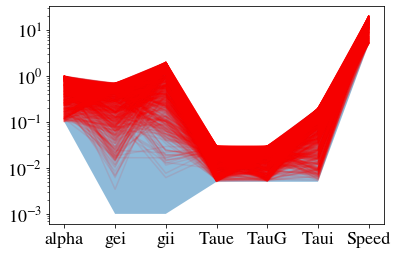

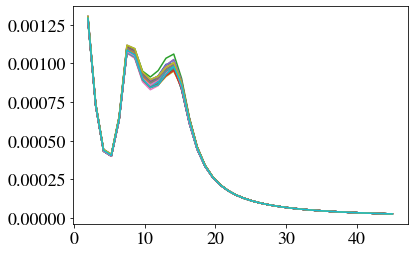

In [10]:
# show demo of generatingt simulation data (Speed is not a constant)
ts = gen_arma_ts(1000).T
sgm_seq = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

#check the reparameterization
plt.fill_between(np.arange(7), paras.par_low, paras.par_high, alpha=0.5)
plt.yscale("log")
for cur_ts_sgm in sgm_seq:
    plt.plot(np.arange(7), cur_ts_sgm, color="red", alpha=0.1)
plt.xticks(np.arange(7), paras.names);
plt.show()
plt.close()
        
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
# check a demo PSD
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
PSD_demo = sgmmodel.run_local_coupling_forward(sgm_seq[1, :])
for ix in range(PSD_demo.shape[1]):
    plt.plot(paras.freqs, PSD_demo[ix, :])

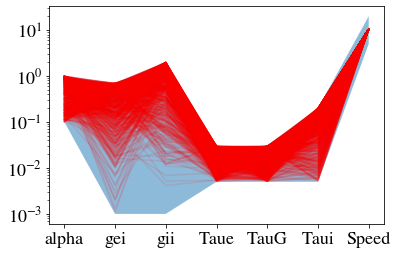

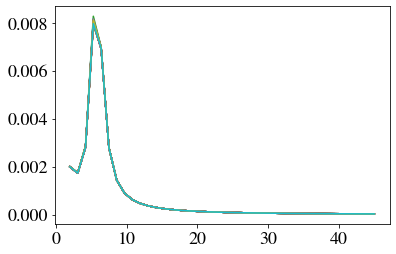

In [31]:
# show demo of generatingt simulation data (Speed is a constant, Mar 30, 2023)
ts_nospeed = gen_arma_ts(1000, 6).T
ts_speed = np.repeat(np.random.randn(1), 1000)
ts = np.concatenate([ts_nospeed, ts_speed.reshape(-1, 1)], axis=1)
sgm_seq = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

#check the reparameterization
plt.fill_between(np.arange(7), paras.par_low, paras.par_high, alpha=0.5)
plt.yscale("log")
for cur_ts_sgm in sgm_seq:
    plt.plot(np.arange(7), cur_ts_sgm, color="red", alpha=0.1)
plt.xticks(np.arange(7), paras.names);
plt.show()
plt.close()
#        
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
## check a demo PSD
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
PSD_demo = sgmmodel.run_local_coupling_forward(sgm_seq[1, :])
for ix in range(PSD_demo.shape[1]):
    plt.plot(paras.freqs, PSD_demo[ix, :])

### Generate simulation data

In [14]:
ts = gen_arma_ts(paras_run.n).T
sgm_seq = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

PSDs = []
for cur_sgm in tqdm(sgm_seq):
    cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
    cur_PSD = cur_PSD[:68, :]
    PSDs.append(cur_PSD)
    
simu_sgm_data = edict()
simu_sgm_data.PSDs = np.array(PSDs)
simu_sgm_data.sgm_params = sgm_seq
save_pkl_dict2folder(RES_ROOT/"simu_sgm_data", simu_sgm_data, is_force=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:53<00:00,  2.83it/s]


In [14]:
ts = gen_arma_ts(paras_run.n).T
sgm_seq = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

PSDs = []
for cur_sgm in tqdm(sgm_seq):
    cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
    cur_PSD = cur_PSD[:68, :]
    PSDs.append(cur_PSD)
    
simu_sgm_data = edict()
simu_sgm_data.PSDs = np.array(PSDs)
simu_sgm_data.sgm_params = sgm_seq
save_pkl_dict2folder(RES_ROOT/"simu_sgm_data", simu_sgm_data, is_force=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:53<00:00,  2.83it/s]


In [250]:
ts = gen_arma_ts(paras_run.n).T
sgm_seq_test = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

PSDs_test = []
for cur_sgm in tqdm(sgm_seq_test):
    cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
    cur_PSD = cur_PSD[:68, :]
    PSDs_test.append(cur_PSD)
    
simu_sgm_data = edict()
simu_sgm_data.PSDs_test = np.array(PSDs_test)
simu_sgm_data.sgm_params_test = sgm_seq_test
save_pkl_dict2folder(RES_ROOT/"simu_sgm_data", simu_sgm_data, is_force=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data/PSDs_test.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data/sgm_params_test.pkl


In [32]:
# Gerenate data when speed is a constant
ts_nospeed = gen_arma_ts(paras_run.n, 6).T
ts_speed = np.repeat(np.random.randn(1), paras_run.n)
ts = np.concatenate([ts_nospeed, ts_speed.reshape(-1, 1)], axis=1)
sgm_seq = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

PSDs = []
for cur_sgm in tqdm(sgm_seq):
    cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
    cur_PSD = cur_PSD[:68, :]
    PSDs.append(cur_PSD)
    
simu_sgm_data = edict()
simu_sgm_data.PSDs = np.array(PSDs)
simu_sgm_data.sgm_params = sgm_seq
save_pkl_dict2folder(RES_ROOT/f"simu_sgm_data_conspeed_{paras_run.n}", simu_sgm_data, is_force=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:10<00:00,  2.70it/s]


/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_params.pkl


In [33]:
# Gerenate data when speed is a constant
ts_nospeed = gen_arma_ts(paras_run.n, 6).T
ts_speed = np.repeat(np.random.randn(1), paras_run.n)
ts = np.concatenate([ts_nospeed, ts_speed.reshape(-1, 1)], axis=1)
sgm_seq = raw2theta_np(ts, paras.prior_bds, k=paras_run.k)

PSDs = []
for cur_sgm in tqdm(sgm_seq):
    cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
    cur_PSD = cur_PSD[:68, :]
    PSDs.append(cur_PSD)
    
simu_sgm_data = edict()
simu_sgm_data.PSDs_test = np.array(PSDs)
simu_sgm_data.sgm_params_test = sgm_seq
save_pkl_dict2folder(RES_ROOT/f"simu_sgm_data_conspeed_{paras_run.n}", simu_sgm_data, is_force=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:45<00:00,  2.89it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs_test.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_params_test.pkl


## Build neural network

### A MLP for SGM

In [152]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_sgm_data")


Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data/PSDs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data/PSDs_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data/sgm_params.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data/sgm_params_test.pkl


In [153]:

# A MLP to approximate SGM model
class SGMnet(nn.Module):
    def __init__(self, nroi, nfreq, is_large=True):
        super(SGMnet, self).__init__()

        output_size = nroi*nfreq
        self.is_large = is_large
        self.nroi = nroi
        self.nfreq = nfreq
        self.lay_init = nn.Linear(7, 256)
        
        self.layers1 = nn.Sequential(
                      nn.Linear(256, 256),
                      nn.ReLU(),
                      nn.Linear(256, 256),
                    )
        self.layers2 = nn.Sequential(
                      nn.Linear(256, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      #nn.Linear(512, 1024),
                      #nn.ReLU(),
                      nn.Linear(512, output_size),
                    )


    def forward(self, x):
        """forward
        """
        x = F.relu(self.lay_init(x))
        if self.is_large:
            residual = x
            x = self.layers1(x)
            x = F.relu(x + residual)
        x = self.layers2(x)
        x = x.reshape(-1, self.nroi, self.nfreq)
        return x



In [154]:
paras_sgm_net = edict()
paras_sgm_net.batchsize = 256
paras_sgm_net.niter = 50000
paras_sgm_net.loss_out = 100

# remove the scale, does not matter
std_PSDs = ((simu_sgm_data.PSDs - simu_sgm_data.PSDs.mean(axis=(1, 2), keepdims=True))/
        simu_sgm_data.PSDs.std(axis=(1, 2), keepdims=True)
       )
std_PSDs_test = ((simu_sgm_data.PSDs_test- simu_sgm_data.PSDs_test.mean(axis=(1, 2), keepdims=True))/
        simu_sgm_data.PSDs_test.std(axis=(1, 2), keepdims=True)
       )
simu_sgm_data_torch = edict()
simu_sgm_data_torch.sgm_params = torch.tensor(simu_sgm_data.sgm_params)
simu_sgm_data_torch.PSDs = torch.tensor(std_PSDs)
simu_sgm_data_torch.sgm_params_test = torch.tensor(simu_sgm_data.sgm_params_test)
simu_sgm_data_torch.PSDs_test = torch.tensor(std_PSDs_test)

In [155]:
def evaluate(X_test, Y_test, net):
    loss_fn = nn.MSELoss()
    net.eval()
    with torch.no_grad():
        Y_test_pred = net(X_test)
        loss = loss_fn(Y_test, Y_test_pred)

    net.train()
    return loss.item()

In [156]:
def random_samples(data):
    """Generate simulation samples with batchsize"""
    idxs = np.random.choice(len(data.sgm_params), paras_sgm_net.batchsize, replace=False)
    idxs = np.sort(idxs)
    X_batch = data.sgm_params[idxs, :]
    Y_batch = data.PSDs[idxs, :]
    return X_batch, Y_batch

In [157]:
sgm_net = SGMnet(nroi=68, nfreq=len(paras.freqs))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(sgm_net.parameters(), lr=1e-4, weight_decay=0)
#optimizer = torch.optim.SGD(sgm_net.parameters(), lr=1e-4)

In [158]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
for ix in range(paras_sgm_net.niter):
    X_batch, Y_batch = random_samples(simu_sgm_data_torch)
    # Zero the gradients
    optimizer.zero_grad()
    
    Y_batch_est = sgm_net(X_batch)
    #print(Y_batch_est.sum(axis=(1, 2)))
    
    loss = loss_fn(Y_batch, Y_batch_est)
    #print(loss)
    # Perform backward pass
    loss.backward()
    
    # Perform optimization
    optimizer.step()
    
    loss_cur = loss_cur + loss.item()
    if ix % paras_sgm_net.loss_out == (paras_sgm_net.loss_out-1):
        losses.append(loss_cur/paras_sgm_net.loss_out)
        losses_test.append(evaluate(simu_sgm_data_torch.sgm_params_test, 
                                    simu_sgm_data_torch.PSDs_test, 
                                   sgm_net))
        print(f"At iter {ix+1}/{paras_sgm_net.niter},"
              f"the losses are {loss_cur/paras_sgm_net.loss_out:.5E} (train)"
              f" and {losses_test[-1]:.5E} (test). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        t0 = time.time()
    

At iter 100/50000,the losses are 7.33924E-01 (train) and 4.84003E-01 (test). The time used is 1.913s. 
At iter 200/50000,the losses are 4.75343E-01 (train) and 4.33473E-01 (test). The time used is 1.886s. 


KeyboardInterrupt: 

In [33]:
trained_model = edict()
trained_model.model = sgm_net
trained_model.loss = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_sgm_net
trained_model.loss = losses
trained_model.loss_test = losses_test
save_pkl_dict2folder(RES_ROOT/"SGM_net", trained_model, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl


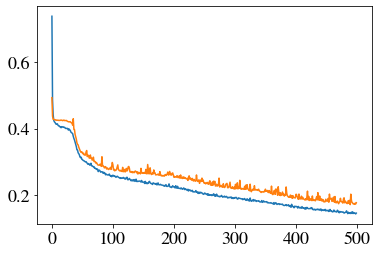

In [34]:
plt.plot(losses)
plt.plot(losses_test)

### LSTM for seq

In [10]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/f"simu_sgm_data_conspeed_{paras_run.n}")


Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_paramss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_paramss_test.pkl


In [12]:
# remove the scale, does not matter
std_PSDs = ((simu_sgm_data.PSDs - simu_sgm_data.PSDs.mean(axis=(1, 2), keepdims=True))/
        simu_sgm_data.PSDs.std(axis=(1, 2), keepdims=True)
       )
std_PSDs_test = ((simu_sgm_data.PSDs_test- simu_sgm_data.PSDs_test.mean(axis=(1, 2), keepdims=True))/
        simu_sgm_data.PSDs_test.std(axis=(1, 2), keepdims=True)
       )
simu_sgm_data_torch = edict()
simu_sgm_data_torch.sgm_paramss = theta2raw_torch(torch.tensor(simu_sgm_data.sgm_paramss), 
                                                 paras.prior_bds, k=paras_run.k)
simu_sgm_data_torch.PSDs = torch.tensor(std_PSDs)
simu_sgm_data_torch.sgm_paramss_test = theta2raw_torch(torch.tensor(simu_sgm_data.sgm_paramss_test), 
                                                      paras.prior_bds, k=paras_run.k)
simu_sgm_data_torch.PSDs_test = torch.tensor(std_PSDs_test)

In [13]:
class LSTM_SGM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, 
                 is_bidirectional=True, 
                prior_bds=None):
        super(LSTM_SGM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.prior_bds = prior_bds
        self.is_bidirectional = is_bidirectional

        self.lstm = nn.LSTM(self.input_dim,
                            self.hidden_dim,
                            num_layers=1,
                            bidirectional=self.is_bidirectional)
        
        if self.is_bidirectional:
            self.fc1 = nn.Linear(2*self.hidden_dim, 256)
            self.laynorm = nn.LayerNorm(2*self.hidden_dim)
        else:
            self.fc1 = nn.Linear(self.hidden_dim, 256)
            self.laynorm = nn.LayerNorm(self.hidden_dim)
        self.fc2 = nn.Linear(256, self.output_dim)
        self.dropout = nn.Dropout(0.5)
            

    def forward(self, seq):
        """
        args:
            seq: should be len_seg x n_batch x len_fs
        return:
            x_raw: x in R scale, should be len_seg x n_batch x output_dim (7)
        """
        x, _ = self.lstm(seq) # len_seg x n_batch x len_fs
        x = self.laynorm(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # len_seg x n_batch x output_dim(7)
        #x_raw = x
        
        x = torch.transpose(x, 1, 0) #  n_batch x len_seg x output_dim(7)
        x_last = x[:, :, -1].mean(axis=-1, keepdims=True).repeat(1, len(seq)).unsqueeze(-1) # n_batch x len_seg x 1
        x_raw = torch.cat([x[:, :, :-1], x_last], dim=-1) #  n_batch x len_seg x output_dim(7)
        x_raw = x_raw.transpose(1, 0) # len_seg x n_batch x output_dim(7)
        
        return x_raw
    
    def theta_raw_2out(self, thetas_raw, k=1):
        """transform reparameterized theta to orignal theta
            args: thetas_raw: an array with num_sps x 7
                  prior_bds: an array with 7 x 2
        """
        thetas = raw2theta_torch(thetas_raw, self.prior_bds, k=k)
        return thetas 

In [14]:
# functions to generate training sample
# note that I fix the bach size = 1
def random_choice(n, batchsize=1):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    #len_seg = torch.tensor(30)
    len_seg = torch.randint(low=10, high=200, size=(1, ))
    up_bd = torch.randint(low=200, high=n, size=(batchsize, ))
    low_bd = up_bd - len_seg
    return low_bd, up_bd


def random_samples_rnn(X, Y, batchsize=1, bds=None):
    """Randomly select a sample from the whole segment
        args:
            data: 
    """
    if bds is None:
        low_bds, up_bds = random_choice(len(X), batchsize)
    else:
        low_bds, up_bds = bds

    X = X.flatten(1)
    X_seqs = []
    Y_seqs = []
    for low_bd, up_bd in zip(low_bds, up_bds):
        X_seq = X[low_bd:up_bd, :].unsqueeze(1)
        Y_seq = Y[low_bd:up_bd].unsqueeze(1)
        X_seqs.append(X_seq)
        Y_seqs.append(Y_seq)
    return torch.cat(X_seqs, dim=1), torch.cat(Y_seqs, dim=1)

In [15]:
def evaluate_rnn(X_test, Y_test, net):
    """args:
            X_test: tensor of len_seg x n_batch x n_fs
            Y_test: tensor of len_seg x n_batch x 7
    """
    loss_fn = nn.MSELoss()
    net.eval()
    with torch.no_grad():
        Y_test_pred = net(X_test)
        loss = loss_fn(Y_test, Y_test_pred)
    net.train()
    return loss.item()

In [16]:
def step_move_rnn_inf(X_test, net, len_seg, move_step, is_bi=False):
    """Do rnn inference with len_seq and move_step 
       For each time, we also inference a seq with length len_seq, 
                    then we only use the results in this seq with length move_step 
                    as predicted Y.
        args:
            X_test: tensor of len_seg x n_batch x n_fs
            is_bi: whether bidirectional RNN or not. 
                   If yes, take the middle part of len_seq. 
                   If no, take the end part.
    """
    if is_bi:
        len_seg_l = int((len_seg-move_step)/2)
    else:
        len_seg_l = len_seg-move_step
    #len_seg_r = len_seg - len_seg_l - move_step
    
    n = X_test.shape[0]
    X_test = X_test.squeeze()
    X_test_batch = []
    for ix in range(0, n, move_step):
        low, up = ix, ix+len_seg
        if (n-up) < move_step:
            up = n
        X_test_batch.append(X_test[low:up])
        if up == n:
            break
    X_test_last_batch = X_test_batch[-1].unsqueeze(1)
    X_test_batch1 = torch.stack(X_test_batch[:-1], dim=1)
    
    net.eval()
    with torch.no_grad():
        Y_test_pred1 = net(X_test_batch1)
        Y_test_last_batch = net(X_test_last_batch)
    net.train()
    begin_part = Y_test_pred1[:len_seg_l, 0, :]
    inner_part = Y_test_pred1[len_seg_l:(len_seg_l+move_step)]
    end_part = Y_test_last_batch[len_seg_l:].squeeze()
    inner_part = inner_part.transpose(1, 0).reshape(-1, 7)
    Y_test_pred = torch.cat([begin_part, inner_part, end_part])
    return Y_test_pred.unsqueeze(1)

In [17]:
paras_rnn = edict()
paras_rnn.batchsize = 128
paras_rnn.niter = 50000
paras_rnn.loss_out = 10
paras_rnn.clip = 10 # from 

paras_rnn.hidden_dim = 512
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*40

In [44]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=True, 
               prior_bds=torch.tensor(paras.prior_bds), 
)
loss_fn = nn.MSELoss()
#optimizer = torch.optim.SGD(rnn.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-4, weight_decay=0)

In [45]:
# training
loss_cur = 0
losses = []
losses_test = []

X_test = simu_sgm_data_torch.PSDs_test.flatten(1).unsqueeze(1)
Y_test = simu_sgm_data_torch.sgm_params_test.unsqueeze(1)
X_train = simu_sgm_data_torch.PSDs.flatten(1).unsqueeze(1)
Y_train = simu_sgm_data_torch.sgm_params.unsqueeze(1)

for ix in range(paras_rnn.niter):
    X_seq, Y_seq = random_samples_rnn(simu_sgm_data_torch.PSDs,
                                      simu_sgm_data_torch.sgm_params, 
                                     batchsize=paras_rnn.batchsize)
    # Zero the gradients
    optimizer.zero_grad()
    
    Y_seq_pred = rnn(X_seq)
    
    loss = loss_fn(Y_seq, Y_seq_pred)
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    loss_cur = loss_cur + loss.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        losses_test.append(evaluate_rnn(X_test, Y_test, rnn))
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.3f} (train)"
              f" and {losses_test[-1]:.3f} (test)."
             )
        loss_cur = 0
        rnn.train()
    

At iter 10/50000, the losses are 3.465 (train) and 3.286 (test).
At iter 20/50000, the losses are 2.870 (train) and 3.125 (test).
At iter 30/50000, the losses are 2.531 (train) and 3.007 (test).
At iter 40/50000, the losses are 2.262 (train) and 2.909 (test).
At iter 50/50000, the losses are 1.983 (train) and 2.852 (test).
At iter 60/50000, the losses are 1.740 (train) and 2.795 (test).
At iter 70/50000, the losses are 1.549 (train) and 2.759 (test).
At iter 80/50000, the losses are 1.339 (train) and 2.736 (test).
At iter 90/50000, the losses are 1.246 (train) and 2.696 (test).
At iter 100/50000, the losses are 1.125 (train) and 2.710 (test).
At iter 110/50000, the losses are 1.009 (train) and 2.717 (test).
At iter 120/50000, the losses are 0.957 (train) and 2.673 (test).
At iter 130/50000, the losses are 0.858 (train) and 2.696 (test).
At iter 140/50000, the losses are 0.850 (train) and 2.732 (test).
At iter 150/50000, the losses are 0.796 (train) and 2.668 (test).
At iter 160/50000, 

KeyboardInterrupt: 

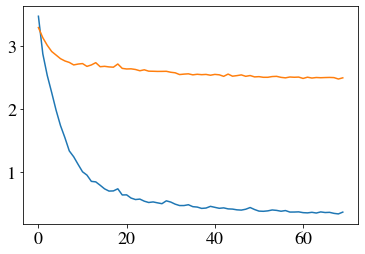

In [46]:
plt.plot(losses)
plt.plot(losses_test)

In [47]:
X_seq, Y_seq = random_samples_rnn(simu_sgm_data_torch.PSDs,
                                  simu_sgm_data_torch.sgm_params,
                                  bds=[[1], [1000]])

In [48]:
idx = -1
rnn.eval()
Y_seq_pred = rnn(X_seq)
Y_seq_pred1 = step_move_rnn_inf(X_seq, rnn, 20, 5)
torch.stack([raw2theta_torch(Y_seq_pred.detach(), paras.prior_bds, k=1)[idx, :, :],
raw2theta_torch(Y_seq_pred1.detach(), paras.prior_bds, k=1)[idx, :, :],
raw2theta_torch(Y_seq[:, :, :], paras.prior_bds, k=1)[idx, :, :]])

tensor([[[4.0737e-01, 3.9892e-01, 8.5546e-01, 2.0771e-02, 1.1690e-02,
          1.7731e-01, 1.4751e+01]],

        [[4.0782e-01, 4.0563e-01, 8.9732e-01, 2.0840e-02, 1.1746e-02,
          1.7624e-01, 1.4737e+01]],

        [[2.8144e-01, 3.9146e-02, 1.8587e+00, 2.4288e-02, 1.0291e-02,
          1.5229e-01, 1.4787e+01]]])

## End to end 

In [18]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/f"simu_sgm_data_conspeed_{paras_run.n}")


Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_paramss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_paramss_test.pkl


In [19]:
# remove the scale, does not matter
std_PSDs = ((simu_sgm_data.PSDs - simu_sgm_data.PSDs.mean(axis=(1, 2), keepdims=True))/
        simu_sgm_data.PSDs.std(axis=(1, 2), keepdims=True)
       )
std_PSDs_test = ((simu_sgm_data.PSDs_test- simu_sgm_data.PSDs_test.mean(axis=(1, 2), keepdims=True))/
        simu_sgm_data.PSDs_test.std(axis=(1, 2), keepdims=True)
       )
simu_sgm_data_torch = edict()
simu_sgm_data_torch.sgm_paramss = theta2raw_torch(torch.tensor(simu_sgm_data.sgm_paramss), 
                                                 paras.prior_bds, k=paras_run.k)
simu_sgm_data_torch.PSDs = torch.tensor(std_PSDs)
simu_sgm_data_torch.sgm_paramss_test = theta2raw_torch(torch.tensor(simu_sgm_data.sgm_paramss_test), 
                                                      paras.prior_bds, k=paras_run.k)
simu_sgm_data_torch.PSDs_test = torch.tensor(std_PSDs_test)

In [20]:
paras_rnn = edict()
paras_rnn.batchsize = 128
paras_rnn.niter = 50000
paras_rnn.loss_out = 10
paras_rnn.lr_step = 50
paras_rnn.clip = 10 # from 

paras_rnn.hidden_dim = 512
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*40

In [101]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net")
sgm_net = trained_model.model

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/optimizer.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl


In [102]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=False, 
               prior_bds=torch.tensor(paras.prior_bds), 
)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.95, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [103]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
for ix in range(paras_rnn.niter):
    X_seq, Y_seq = random_samples_rnn(simu_sgm_data_torch.PSDs,
                                      simu_sgm_data_torch.sgm_params, 
                                     batchsize=paras_rnn.batchsize)
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_raw_pred = rnn(X_seq)
    theta_pred = raw2theta_torch(theta_raw_pred, torch.tensor(paras.prior_bds), k=1)
    PSD_pred = sgm_net(theta_pred.flatten(0, 1))
    X_pred = PSD_pred.flatten(1)
    loss = loss_fn(X_seq.flatten(0, 1), X_pred)
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    loss_cur = loss_cur + loss.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.3f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        rnn.train()
        t0 = time.time()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()

At iter 10/50000, the losses are 0.368 (train).The time used is 13.276s. 
At iter 20/50000, the losses are 0.244 (train).The time used is 12.870s. 
At iter 30/50000, the losses are 0.213 (train).The time used is 16.623s. 
At iter 40/50000, the losses are 0.192 (train).The time used is 9.051s. 
At iter 50/50000, the losses are 0.185 (train).The time used is 13.508s. 
Adjusting learning rate of group 0 to 9.5000e-05.
At iter 60/50000, the losses are 0.177 (train).The time used is 14.494s. 
At iter 70/50000, the losses are 0.176 (train).The time used is 12.792s. 
At iter 80/50000, the losses are 0.169 (train).The time used is 9.000s. 
At iter 90/50000, the losses are 0.165 (train).The time used is 15.085s. 
At iter 100/50000, the losses are 0.160 (train).The time used is 16.376s. 
Adjusting learning rate of group 0 to 9.0250e-05.
At iter 110/50000, the losses are 0.158 (train).The time used is 20.577s. 
At iter 120/50000, the losses are 0.157 (train).The time used is 23.381s. 
At iter 130

KeyboardInterrupt: 

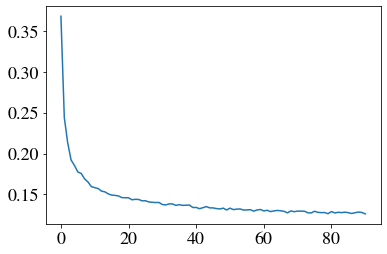

In [104]:
plt.plot(losses)

In [105]:
trained_uni_model = edict()
trained_uni_model.model = rnn
trained_uni_model.loss = loss_fn
trained_uni_model.optimizer = optimizer
trained_uni_model.scheduler = scheduler
trained_uni_model.paras = paras_rnn
trained_uni_model.loss = losses
save_pkl_dict2folder(RES_ROOT/"LSTM_net", trained_uni_model, is_force=True)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net/scheduler.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_net/paras.pkl


In [21]:
trained_uni_model = load_pkl_folder2dict(RES_ROOT/"LSTM_net")
rnn  = trained_uni_model.model

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/LSTM_net/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/LSTM_net/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/LSTM_net/optimizer.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/LSTM_net/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/tests/../../mypkg/../results/LSTM_net/scheduler.pkl


In [22]:
X_seq, Y_seq = random_samples_rnn(simu_sgm_data_torch.PSDs,
                                  simu_sgm_data_torch.sgm_paramss, 
                                     bds=[[0], [1000]])
rnn.eval()
theta_pred_raw = rnn(X_seq)
theta_pred = raw2theta_torch(theta_pred_raw, torch.tensor(paras.prior_bds), k=1).squeeze().detach()
theta_true = raw2theta_torch(Y_seq, torch.tensor(paras.prior_bds), k=1).squeeze()

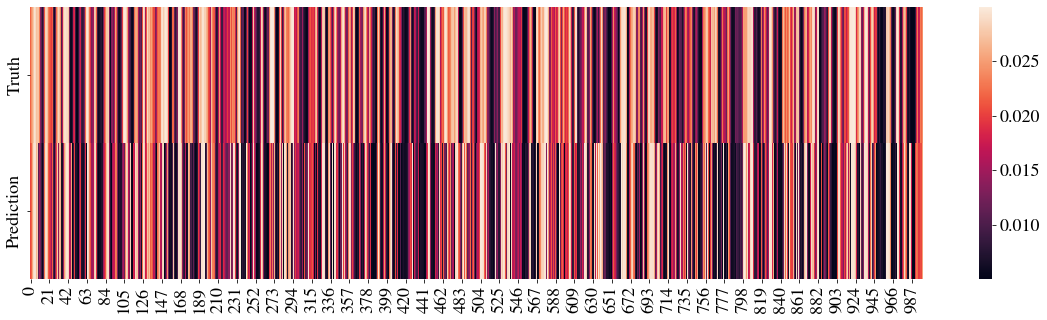

In [23]:
idx = 3
con_data = np.array([
           theta_true[:, idx].numpy(),
           theta_pred[:, idx].numpy()])
plt.figure(figsize=[20, 5])
sns.heatmap(con_data)
plt.yticks([0.5, 1.5], ["Truth", "Prediction"]);

In [25]:
for ix in range(6):
    res = scipy.stats.pearsonr(theta_true[:, ix].numpy(), theta_pred[:, ix].numpy())
    print(res)


(0.058130885153010806, 0.06613392741827502)
(0.020939403939660782, 0.5083517040251809)
(0.011229303616572775, 0.7228377205757553)
(0.6693352458238642, 6.308000039299866e-131)
(0.7284711721087906, 4.0460856714436255e-166)
(0.09365753436512203, 0.0030315033606022465)
